<a href="https://colab.research.google.com/github/kay-squared/PyTorchLearn/blob/main/04_pytorch_CustomDatasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datsets Vidwo Notebook

**Reources:**
* Book version: https://www.learnpytorch.io/04_pytorch_custom_datasets/
* github repo: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb
* Discussions on : https://github.com/mrdbourke/pytorch-deep-learning/discussions

We have used some datasets on Pytorch before, but how to you get your own data into Pytorch?

## Domain libraries
Depending on your problem (test, imiages, audio...), you may want to look into each of the PyTorch existinign data loading functions and customizable data loading functions

# 0. Import and set up device agnostic code


In [9]:
import torch
from torch import nn
torch.__version__

'1.13.1+cu116'

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Download some data
* We will build food vision mini. SO get food dataset. Go to torchvision and check out datasets
* Use the Food181 data set of torchvision, but make it smaller
* find a Notebook which does so here: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb
* but the data are also provided on the deep learning repo of the course: https://github.com/mrdbourke/pytorch-deep-learning/tree/main/data so we will be using this


In [11]:
# Get dataset from github
import requests
import zipfile
from pathlib import Path 

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# make diretory if does not exist
if image_path.is_dir():
  print(f"{image_path} directory already exists ... Skipping download. ")
else:
  print(f"{image_path} does not exist, creatinig path.")
  image_path.mkdir(parents=True, exist_ok=True)

# download data into data path (raw link adress!)
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading Pizza Steak and Sushi data")
  f.write(request.content)

# unzip it into image path
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip","r") as zip_ref:
  print(f"Unzipping Pizza Steak and Sushi data.")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi directory already exists ... Skipping download. 
Unzipping Pizza Steak and Sushi data.


## 2. Data preparation and exploratioin

In [12]:
# walking through directory (standard imiage classification data)
import os
def walk_through_data(dir_path):
  """ Walks through dir_path and returns its content """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [13]:
walk_through_data(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza


In [14]:
# Set up train and test paths - THIS IS STANDARD SETUP (there may also be a validation path)
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize image
1. Get all image paths
2. Pick a random image path using Pzthons random.choise()
3. Get the image class name using "pathlib.Path.parent.stem"
4. Open miage with python PIL
5. Show image and print metadata


Have a look at https://pytorch.org/vision/stable/utils.html. - there are tons of ways to manipuate and do stuff with images (including segementation adn bounding boxes)

In [15]:
import random
from PIL import Image

 Random image path: data/pizza_steak_sushi/train/pizza/1649276.jpg
Image Class: pizza
Image height: 384
Image width: 512


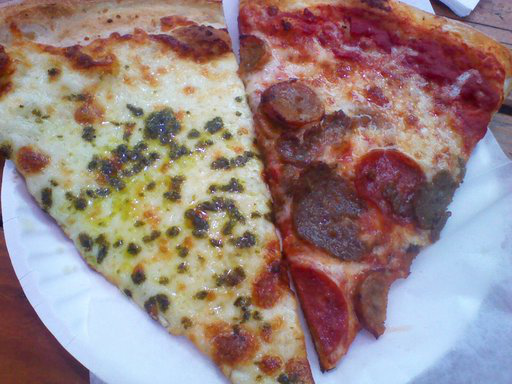

In [16]:
#random.seed(42)

# 1. Get image paths (all of them)
image_path_list = list ( image_path.glob("*/*/*.jpg") ) # mirrors depth of directory tree> test train / pizza steak sushi / jpg
#image_path_list

# 2. pick a random image
random_image_path = random.choice(image_path_list)
random_image_path

# 3. Get image class by looking at the name of the parent directory
image_class = random_image_path.parent.stem
image_class

# 4. use PIL  Image class to opem image
img = Image.open(random_image_path)

# 5. Print metadata
print(f" Random image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

#

(-0.5, 511.5, 383.5, -0.5)

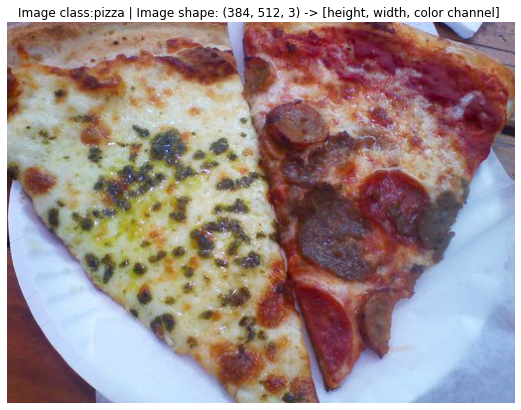

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# to plot with matplotlib, need to convert to numpy array
img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))

plt.imshow(img_as_array)
plt.title(f"Image class:{image_class} | Image shape: {img_as_array.shape} -> [height, width, color channel] ")
plt.axis(False)


# not that PIL has color channel last!!! unlike pytorch

## 3. Transforming data

1. Convert data to pytorch tensor format: here: numerical representaiton of images
2. turn it into a torch.utils.data.Dataset and subsequently into a torch.utils.data.DataLoader. We will call this Dataset and Dataloader

In [18]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transform data with torchvision.transforms

In [19]:
# transform from image
data_transform = transforms.Compose([
    # resize images to 64 x 64
    transforms.Resize(size=(64,64)),
    # Flip images randomly - useful for augmentation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor() 
                                     ])

In [20]:
data_transform(img).shape
data_transform(img).dtype
data_transform(img)

tensor([[[0.5686, 0.5451, 0.4902,  ..., 0.5725, 0.5843, 0.5804],
         [0.5529, 0.5294, 0.5098,  ..., 0.5725, 0.5882, 0.6039],
         [0.5490, 0.4980, 0.5294,  ..., 0.5137, 0.5569, 0.6000],
         ...,
         [0.5216, 0.5098, 0.5216,  ..., 0.3961, 0.3961, 0.4039],
         [0.5333, 0.5216, 0.5294,  ..., 0.4000, 0.4078, 0.4118],
         [0.5255, 0.5137, 0.5176,  ..., 0.4000, 0.4118, 0.4196]],

        [[0.4863, 0.4706, 0.4353,  ..., 0.4431, 0.4824, 0.4824],
         [0.4902, 0.4706, 0.4510,  ..., 0.3961, 0.4157, 0.4588],
         [0.4824, 0.4549, 0.4706,  ..., 0.3137, 0.3569, 0.4314],
         ...,
         [0.6235, 0.6275, 0.6353,  ..., 0.2000, 0.2000, 0.2039],
         [0.6353, 0.6235, 0.6196,  ..., 0.2039, 0.2039, 0.2078],
         [0.6157, 0.6196, 0.6235,  ..., 0.2000, 0.2000, 0.2039]],

        [[0.5608, 0.5529, 0.5255,  ..., 0.4431, 0.5255, 0.5569],
         [0.5529, 0.5529, 0.5373,  ..., 0.3098, 0.3608, 0.4353],
         [0.5490, 0.5294, 0.5412,  ..., 0.2392, 0.2824, 0.

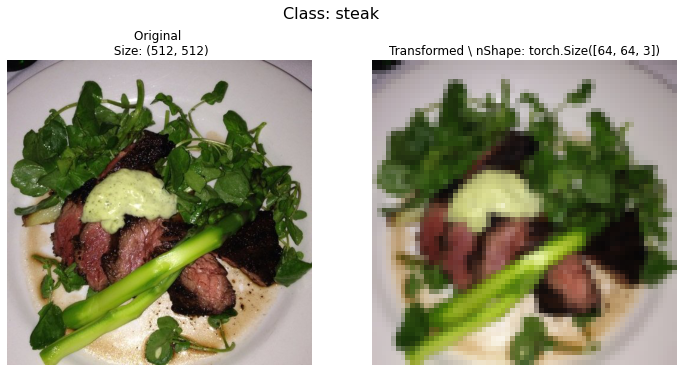

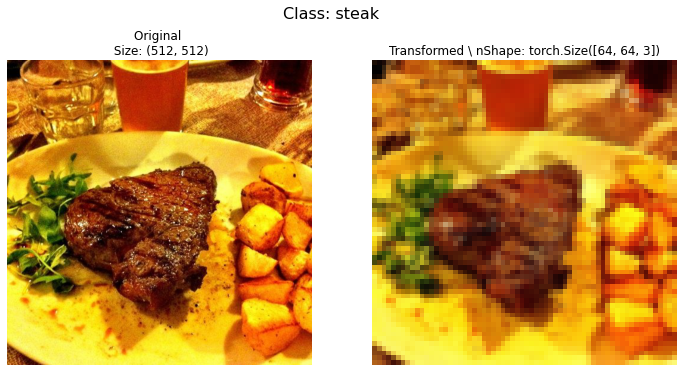

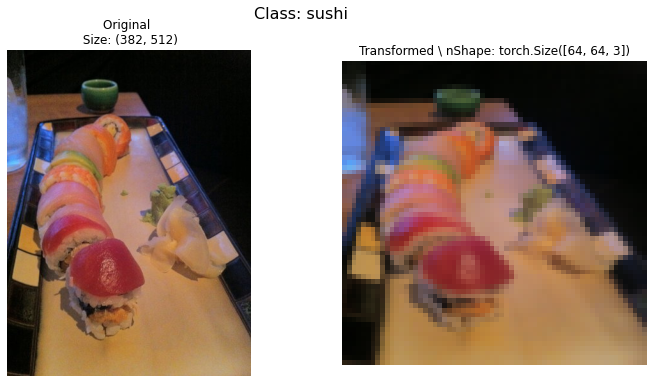

In [21]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  selects random image form the path list, loads and 
  transforms them, then plots original and transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)  # choose n images
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2,figsize=(12,6))
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis(False)

      # transform
      transformed_image = transform(f).permute(1,2,0)    # will need to change for matplotlib, because of color channels first
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \ nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list, 
                        transform = data_transform,
                        n=3,
                        seed=42)


## 4. Option 1: Loading image data using `ImageFolder`

Look at https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

We can load image classification data using `torchvision.datasets.ImageFolder`

Using this type of prebuit function is possible because the directory is in standard format for image classificatin







In [22]:
# use imagefolder
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform,
                                  target_transform=None)

In [23]:
train_data, test_data.classes


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), ['pizza', 'steak', 'sushi'])

#### Check out some attributes that come with `ImageFolder`
type train_data.   

and wait what comes up

In [24]:
# Get classnames as a list, this seems to be a built in class, but i dont know where the information comes from
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [25]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [26]:
# check the lengths of the dataset
len(train_data), len(test_data)

(225, 75)

In [27]:
# Get index on the train data set to get a single image and a labe
train_data[0]    # gibes image and label


img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: {img}")
print(f"Image shape: {img.shape}")
print(f"Image data=type: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64])
New shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

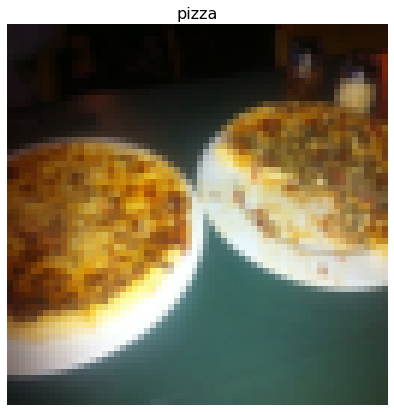

In [28]:
# plot wiiht matplotlib> rearrange order of dimensions

img_permute = img.permute(1,2,0)

print(f"Original shape: {img.shape}")
print(f"New shape: {img_permute.shape}")

plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label],fontsize=16)

#### Now make a dataloader

In [29]:
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True, num_workers=os.cpu_count())
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle = False, num_workers = os.cpu_count())

print(f"Length of train_dataloader: {len(train_dataloader)}")
print(f"Length of test dataloader: {len(test_dataloader)}")

Length of train_dataloader: 8
Length of test dataloader: 3


In [30]:
img, label = next(iter(train_dataloader))
print(f"Image shape: {img.shape} --> [BATCH_SIZE, color_channels, height, width]")
print(f"Label shape: {label.shape}")


Image shape: torch.Size([32, 3, 64, 64]) --> [BATCH_SIZE, color_channels, height, width]
Label shape: torch.Size([32])


# 5. Build a CNN

In [31]:
from torch import nn

class CNN(nn.Module):
  def __init__(self, input_channels, output_features, hidden_units):
    super().__init__()
    n_hidden_layers = len(hidden_units)
    self.layers = nn.ModuleList()
    self.layers.append(nn.Conv2d(in_channels = input_channels,
                                 out_channels = hidden_units[0],
                                 kernel_size=3,
                                 stride=1,
                                 padding=1))
    self.layers.append(nn.ReLU())
    self.layers.append(nn.MaxPool2d(kernel_size=2,
                                  stride=2))

    for k in range(n_hidden_layers-1):
      self.layers.append(nn.Conv2d(in_channels = hidden_units[k], 
                                   out_channels = hidden_units[k+1],
                                   kernel_size=3,
                                   stride=1,
                                   padding=1
                                   ))
      self.layers.append(nn.ReLU())

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=16384, 
                  out_features = output_features)
    )
  def forward(self,x):
    for layer in self.layers:
      x = layer(x)
    x = self.classifier(x)
    return x


  

In [32]:
img, label=next(iter(train_dataloader))
img.shape

torch.Size([32, 3, 64, 64])

In [33]:


model_0 = CNN(input_channels = img.shape[1],
              output_features = len(class_names),
              hidden_units=[16,16]).to(device)

model_0

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.001)
model_0

CNN(
  (layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=3, bias=True)
  )
)

In [34]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               #accuracy_fn,
               device: torch.device):
    model.train()
    train_loss = 0
    #train_acc=0
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)
    
        y_pred = model(X)
        loss = loss_fn(y_pred,y)            # loss per batch (32 samples)
        train_loss+=loss
        #train_acc += accuracy_fn(y_pred.argmax(dim=1),y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%400 ==0:
            pass
          #print(f'Have looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')
          #(f"Current sample: {batch*len(X)}/{len(dataloader.dataset)}")
  
  
    train_loss /= len(dataloader)    # average loss per batch
    #train_acc /= len(train_dataloader)
    
    return model, train_loss


def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               #accuracy_fn,
               device: torch.device
              ):
    test_loss = 0
    #test_acc = 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred,y)
            #test_acc += accuracy_fn(y_pred.argmax(dim=1),y)

        test_loss /= len(dataloader)
        #test_acc /= len(test_dataloader)

    return  test_loss


from timeit import default_timer as timer
def print_train_time(start: float,
                     end:float,
                     device: torch.device = None):
  """ Prints difference between start and end time """
  total_time = end - start
  print(f'Total time on {device}: {total_time:.3f} seconds')
  return total_time

In [35]:
from tqdm.auto import tqdm
train_time_start=timer()

epochs = 50

epoch_count=[]
train_lossList = []
test_lossList = []

for epoch in tqdm(range(epochs)):
  model_0.train()
  model_0, train_loss = train_step(model = model_0,
                                   dataloader = train_dataloader,
                                   loss_fn = loss_fn,
                                   optimizer= optimizer,
                                   device = device)
  
  test_loss = test_step(model = model_0,
                                   dataloader = test_dataloader,
                                   loss_fn = loss_fn,
                                   optimizer= optimizer,
                                   device = device)
  
  print(f"Epoch: {epoch} | Traiin loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")


  train_time_end = timer()
  total_train_time_model_0 = print_train_time(train_time_start,
                                              train_time_end,
                                              device = str(next(model_0.parameters()).device))
  



  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Traiin loss: 1.1003 | Test loss: 1.0781
Total time on cuda:0: 7.511 seconds
Epoch: 1 | Traiin loss: 1.0948 | Test loss: 1.0680
Total time on cuda:0: 8.885 seconds
Epoch: 2 | Traiin loss: 1.1029 | Test loss: 1.0894
Total time on cuda:0: 10.241 seconds
Epoch: 3 | Traiin loss: 1.1086 | Test loss: 1.1048
Total time on cuda:0: 11.619 seconds
Epoch: 4 | Traiin loss: 1.0990 | Test loss: 1.0847
Total time on cuda:0: 12.998 seconds
Epoch: 5 | Traiin loss: 1.1015 | Test loss: 1.1074
Total time on cuda:0: 14.353 seconds
Epoch: 6 | Traiin loss: 1.0952 | Test loss: 1.1182
Total time on cuda:0: 15.729 seconds
Epoch: 7 | Traiin loss: 1.0881 | Test loss: 1.1313
Total time on cuda:0: 17.090 seconds
Epoch: 8 | Traiin loss: 1.0843 | Test loss: 1.1408
Total time on cuda:0: 18.456 seconds
Epoch: 9 | Traiin loss: 1.0896 | Test loss: 1.1407
Total time on cuda:0: 20.121 seconds
Epoch: 10 | Traiin loss: 1.0791 | Test loss: 1.1488
Total time on cuda:0: 21.809 seconds
Epoch: 11 | Traiin loss: 1.1003 |

## 5. Option 2: Loading images with Custom Dataset: Replicating the `ImageFolder`

1. class should load data from folder structure
2. get class_names from dataset
3. get classes as dictioary from dataset
such that it can be put into dataloader


Check out https://pytorch.org/vision/stable/datasets.html

`torch.utils.data.Dataset` is the base dataset class, we want to build on top of this.

Many custom datasets in Pytorch sublcass this: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

Pros:
* Can create a `Datset` out of almost anythinig
* not limited to PyTorch pre-built `Dataset` functions
Cons
* Even though you could create `Dataset out of almost anything, it doesnt mean it will work
* usinig a custom `Dataset` means a lot of code, will be error-prone

In [36]:

import os
import torch
import pathlib
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List



In [37]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx 
# gettgin classes from a directorz and assigning an index (in a dictionary)
# is what should be recreated

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 A helper function to get class names from a directory